In [1]:
run __init__.py

In [2]:
import pandas as pd
import numpy as np
from joblib import load, dump
from finnhub_api import Finnhub
from datetime_util import timestamp2datetime, str2date, str2datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from time_series import TS

## Stock Market TimeSeries

In [4]:
finnhub_key = load('./finnhub/finnhub_key.pkl', 'rb')

In [5]:
fin_5m = Finnhub(finnhub_key, "2021-05-15", "2021-05-31", "AAPL")
aapl_5m = fin_5m.stock_candles("5")

hist_cols = ['close', 'high', 'low', 'open', 'status','date', 'volume']
aapl_5m_df = pd.DataFrame(aapl_5m)
aapl_5m_df.columns = hist_cols
aapl_5m_df['date'] = aapl_5m_df['date'].apply(lambda x: timestamp2datetime(x))
aapl_5m_df['date'] = pd.to_datetime(aapl_5m_df['date'], format='%Y-%m-%d %H:%M:%S')#.dt.normalize()
aapl_5m_df.set_index('date', inplace=True)

In [6]:
aapl_5m_df.to_csv('./data/apple_5m.csv',index=True)

In [7]:
aapl_5m_df = pd.read_csv('./data/apple_5m.csv', parse_dates=['date'], date_parser=str2datetime)
aapl_5m_df.set_index('date', inplace=True)

In [8]:
aapl_5m_df.head()

,close,high,low,open,status,volume
date,,,,,,
2021-05-17 04:00:00,126.90,127.00,126.81,126.96,ok,3209
2021-05-17 04:05:00,126.93,126.93,126.86,126.86,ok,3663
2021-05-17 04:15:00,126.83,126.83,126.83,126.83,ok,692
2021-05-17 04:20:00,126.81,126.81,126.81,126.81,ok,333
2021-05-17 04:45:00,127.23,127.23,127.23,127.23,ok,382


In [10]:
date = pd.to_datetime("2021-05-28")
ts_origin = aapl_5m_df.loc[aapl_5m_df.index.date == date, 'close']
roll = 6

## Dickey-Fuller Test

In [11]:
ts = TS()

In [12]:
ts.adf_test(ts_origin)

Test Statistic                  -1.726718
p-value                          0.417402
#Lags Used                       2.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64

## Time Series Testing Trend

#### Rolling Statistics

In [13]:
ts_orig_roll_mean = ts_origin.rolling(roll).mean()

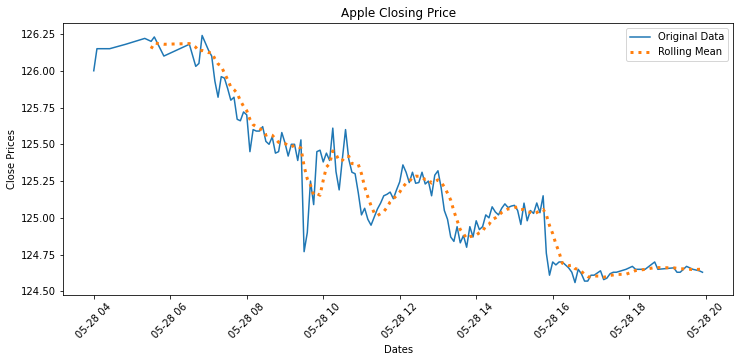

In [14]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Apple Closing Price')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', linewidth=3, label='Rolling Mean')
# ax.legend()
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Removing Trends

In [15]:
ts_log = np.log(ts_origin)
ts_sqrt = np.sqrt(ts_origin)
ts_log_roll_mean = ts_log.rolling(roll).mean()
ts_sqrt_roll_mean = ts_sqrt.rolling(roll).mean()

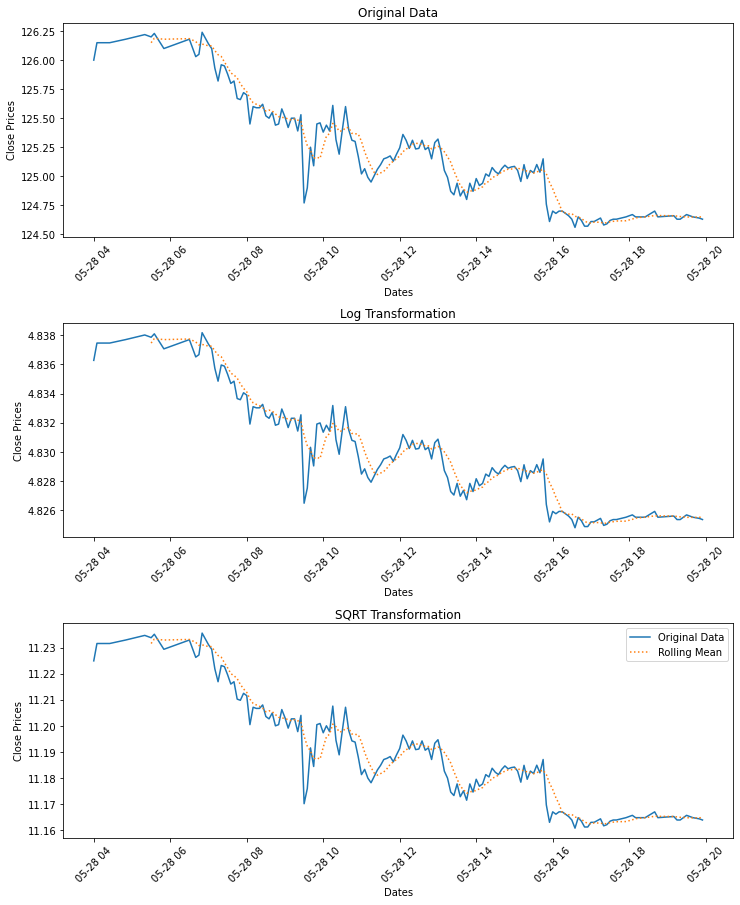

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=False, figsize=(12,15))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Log Transformation')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_log, label='Original Data')
ax2.plot(ts_log_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax3.grid(False)
ax3.set_xlabel('Dates')
ax3.set_ylabel('Close Prices')
ax3.set_title('SQRT Transformation')
ax3.tick_params(axis='x', labelrotation=45)
ax3.plot(ts_sqrt, label='Original Data')
ax3.plot(ts_sqrt_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing the rolling mean

In [17]:
ts_origin_min_roll_mean = (ts_origin - ts_origin.rolling(roll).mean())

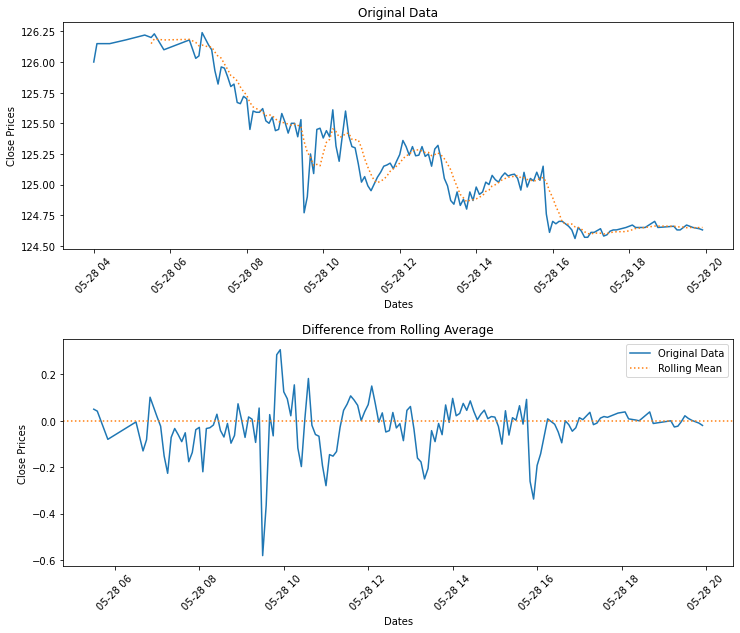

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Rolling Average')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin_min_roll_mean, label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing with the weighted rolling mean

In [19]:
ts_ewm = ts_origin.ewm(halflife=6).mean()

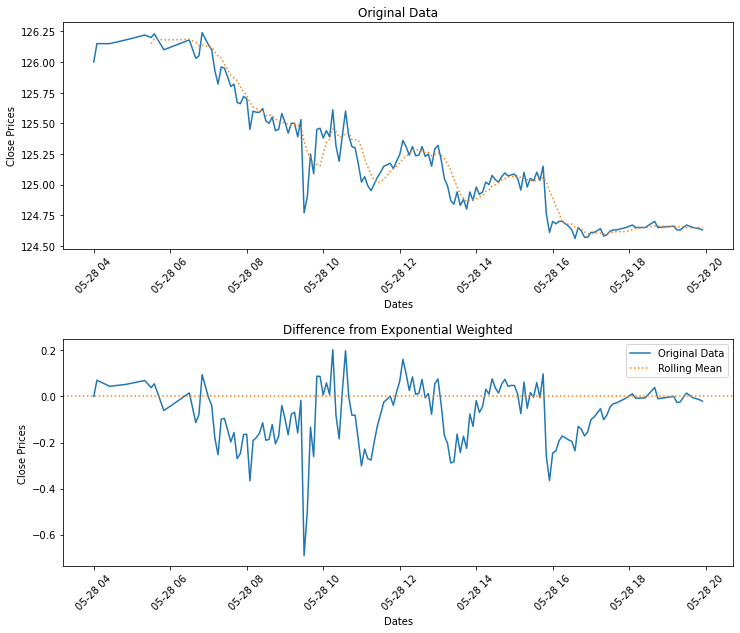

In [20]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))

ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Exponential Weighted')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin - ts_ewm, label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing

Using differencing method to transform the time series by taking the difference of 6 lags between consecutive observations 
to remove the series dependence on time "temporal dependence" 

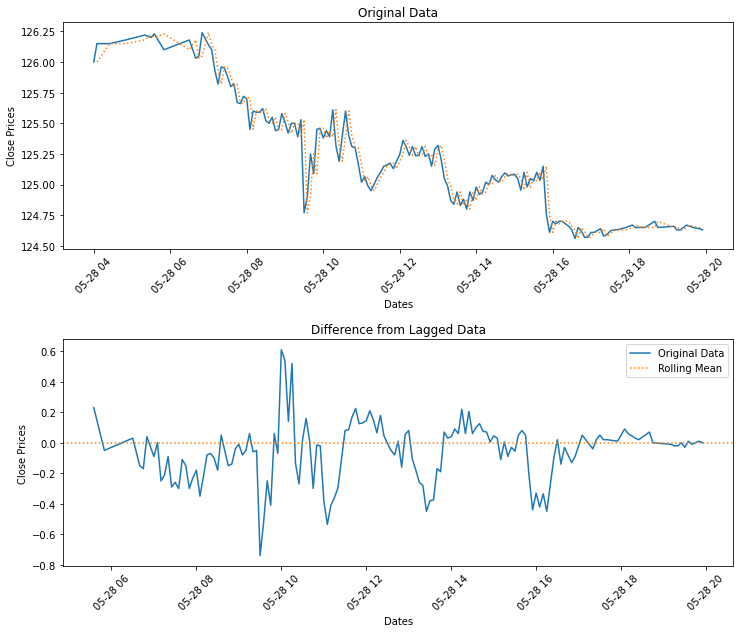

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))

ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_origin.shift(1), color='tab:orange', ls='dotted', label='Original Data')

ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Lagged Data')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin.diff(roll), label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

In [22]:
decomposition = seasonal_decompose(ts_log, period=3)

In [23]:
ts_trend = decomposition.trend
ts_seasonal = decomposition.seasonal

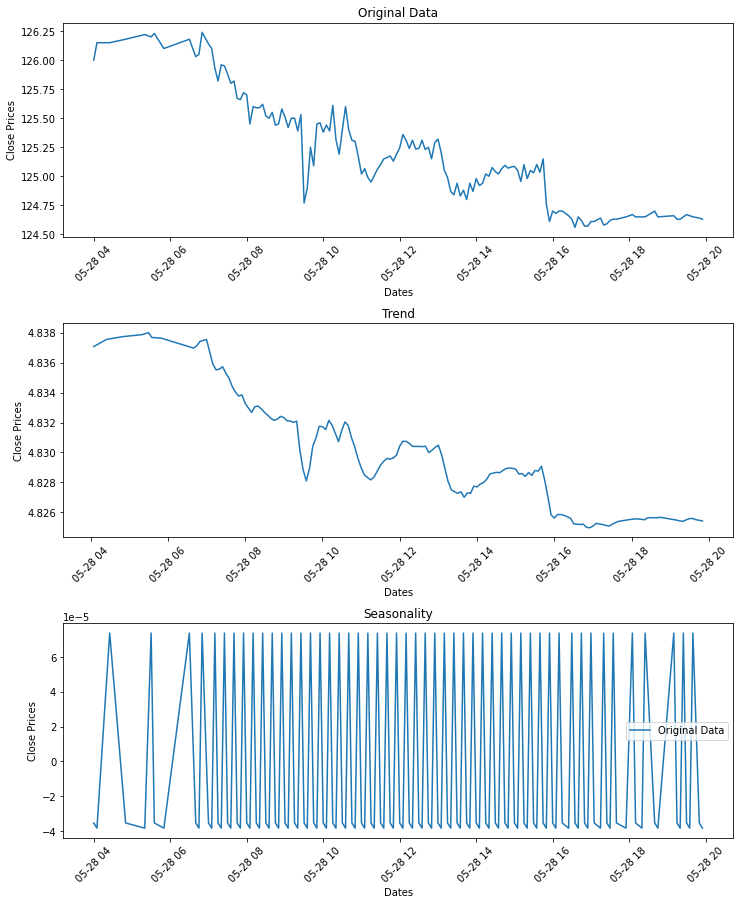

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(12,15))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Trend')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_trend, label='Original Data')

ax3.grid(False)
ax3.set_xlabel('Dates')
ax3.set_ylabel('Close Prices')
ax3.set_title('Seasonality')
ax3.tick_params(axis='x', labelrotation=45)
ax3.plot(ts_seasonal, label='Original Data')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

In [25]:
ts.adf_test(ts_seasonal)

Test Statistic                -1.525009e+16
p-value                        0.000000e+00
#Lags Used                     1.000000e+01
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64

In [26]:
ts_diff = ts_origin.diff(roll).dropna()
ts.adf_test(ts_diff)

Test Statistic                  -4.233531
p-value                          0.000578
#Lags Used                      12.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64

In [27]:
ts = TS()

In [28]:
train_range = (aapl_5m_df.index <= pd.to_datetime("2021-05-28 11:30:00"))
train = aapl_5m_df.loc[train_range,'close'].to_period("5T")

test_range = (
            (aapl_5m_df.index >= pd.to_datetime("2021-05-28 11:30:00"))
            &
            (aapl_5m_df.index <= pd.to_datetime("2021-05-28 12:00:00"))
            )
test = aapl_5m_df.loc[test_range, 'close'].to_period("5T")

In [29]:
endog = aapl_5m_df.loc[:,'close'].to_period("5T")
best_params = ts.sarimax_best_param(endog, 6)

In [30]:
sarimax_model = ts.sarimax_model(train, best_params[0], best_params[1])

In [31]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1415
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 918.748
Date:                Thu, 03 Jun 2021   AIC                          -1831.496
Time:                        17:50:03   BIC                          -1815.738
Sample:                    05-17-2021   HQIC                         -1825.608
                         - 05-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6399      0.187      3.417      0.001       0.273       1.007
ma.L1         -1.4480      0.376     -3.846      0.000      -2.186      -0.710
sigma2         0.0076      0.004      1.924      0.054      -0.000       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):              4868.97
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

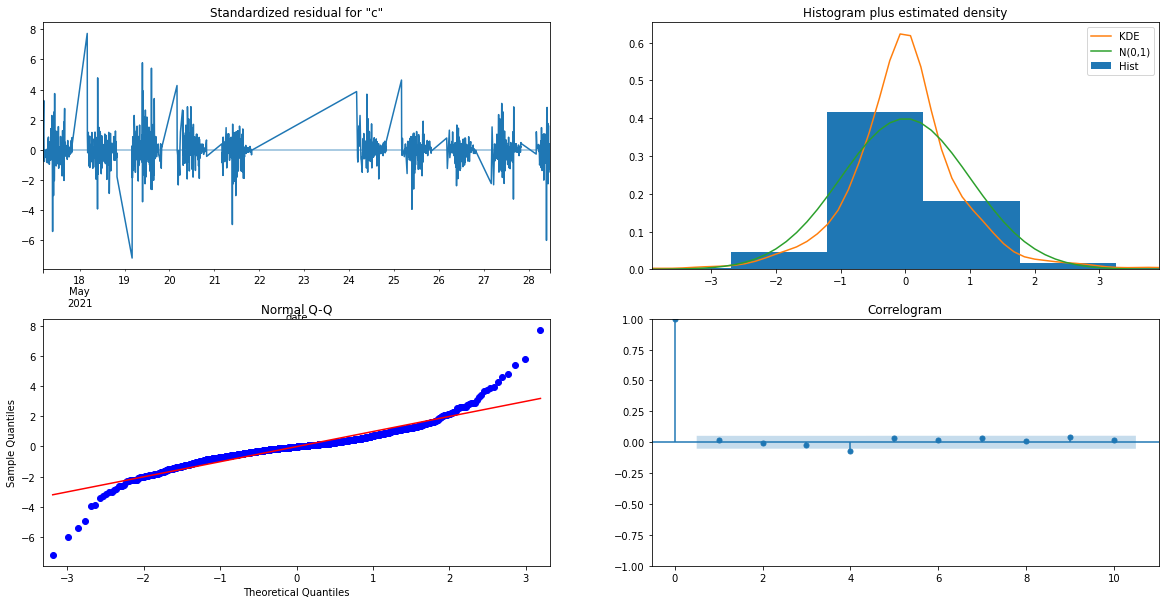

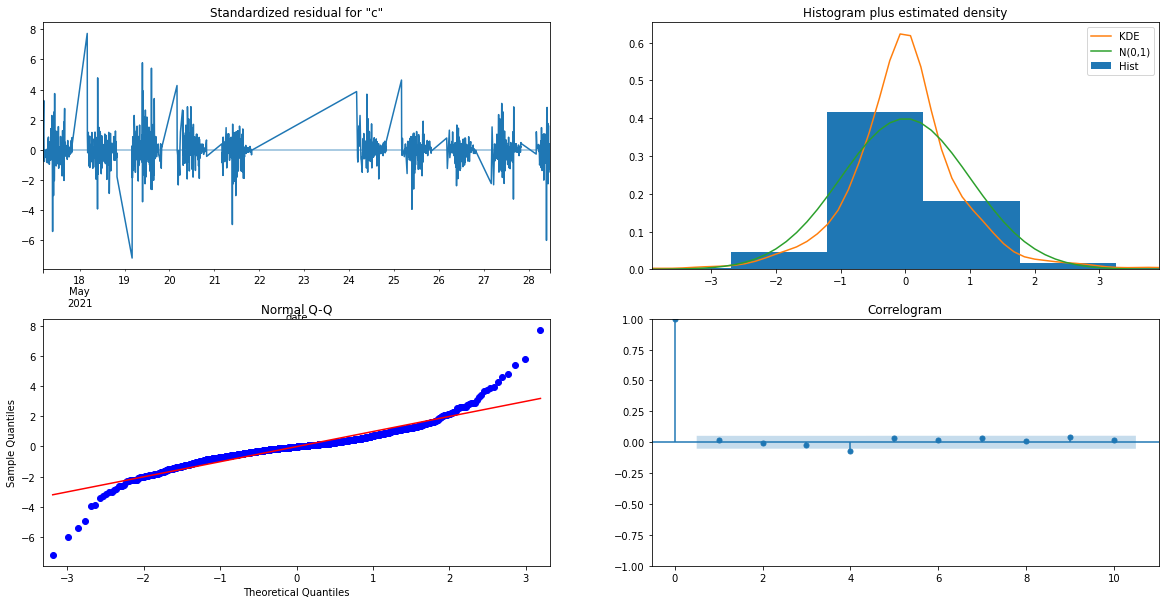

In [32]:
sarimax_model.plot_diagnostics(figsize=(20,10))

In [33]:
pred = sarimax_model.get_prediction(
    start=pd.to_datetime("2021-05-28 11:30:00"),
    end=pd.to_datetime("2021-05-28 12:00:00"),
    dynamic=False)

In [39]:
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()
prediction = pred.predicted_mean
prediction.index = prediction.index.to_timestamp()
Conf_interval = pred.conf_int()

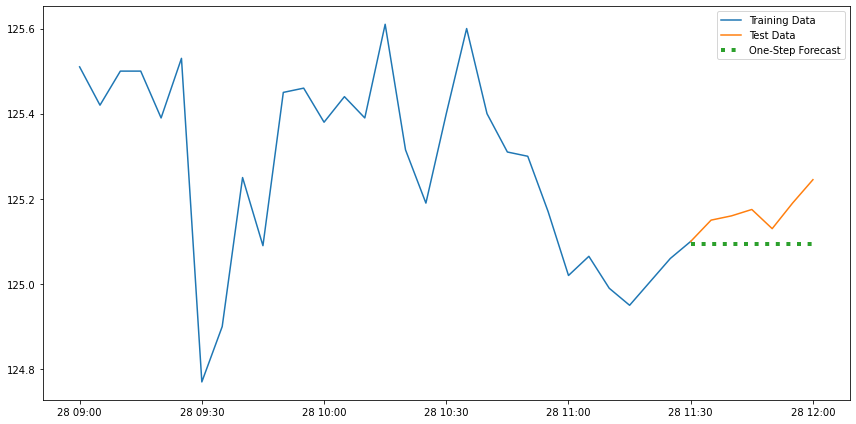

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.loc["2021-05-28 09:00:00":,], label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(prediction.loc["2021-05-28 11:30:00":], label='One-Step Forecast', linewidth=4, ls=':')
# ax.fill_between(Conf_interval.index.to_timestamp(),
#                 Conf_interval.iloc[:,0],
#                 Conf_interval.iloc[:,1],
#                 color='gray',
#                 alpha=.5)
ax.legend()
fig.tight_layout()